# Analyzing unique peaks—are they true peaks, or are they false positives?

In [1]:
import os
os.chdir('/home/katie/bp_repo/reports/')

from util import import_shap_scores, import_peak_table, import_profiles, import_tfmodisco_results
from util import trim_motif_by_ic
from util import figure_to_vdom_image
from viz_sequence import plot_weights
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from IPython.display import display
import tqdm

import sys
sys.path.append('/home/katie/bp_repo/multitask_profile_model_SPI_GATA/')
from plotting_helper import *
from all_functions import *
from profile_models import ModelLoader

tqdm.tqdm_notebook()

plt.rcParams["figure.dpi"] = 130

/tmp/ipykernel_34785/2721166645.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm.tqdm_notebook()


0it [00:00, ?it/s]

In [2]:
# load in preds
path = '/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/'

preds_dict = {}
keys = ['CTCF_chip_model_shared_chip_loader_fake_controls',
 'CTCF_cut_model_shared_chip_loader',
 'CTCF_chip_model_shared_cut_loader_fake_controls',
 'CTCF_cut_model_shared_cut_loader',
 'CTCF_chip_model_unique_chip_loader_fake_controls',
 'CTCF_cut_model_unique_chip_loader',
 'CTCF_chip_model_unique_cut_loader_fake_controls',
 'CTCF_cut_model_unique_cut_loader',
 'FOSL2_chip_model_shared_chip_loader_fake_controls',
 'FOSL2_cut_model_shared_chip_loader',
 'FOSL2_chip_model_shared_cut_loader_fake_controls',
 'FOSL2_cut_model_shared_cut_loader',
 'FOSL2_chip_model_unique_chip_loader_fake_controls',
 'FOSL2_cut_model_unique_chip_loader',
 'FOSL2_chip_model_unique_cut_loader_fake_controls',
 'FOSL2_cut_model_unique_cut_loader']

# the surprisingly quick (few secs) actual preds loading
for key in keys:
    true_profs, pred_profs, coords = import_profiles(f'{path}{key}.preds')
    preds_dict[key] = {'true_profs': true_profs, 'pred_profs': pred_profs, 'coords': coords}
    
# n.b. pred_profs are a probability distribution summing to 1 (across each strand)

# because of reverse complement augmentation, we need to:
# 1. take the coords, make into a DataFrame, drop duplicates, and get the indexes of the unique coords
# 2. use the unique indexes to subset true_profs and pred_profs into the unique profs (getting rid of rev comp)
for key in preds_dict:
    preds_dict[key]['coords_unique'] = pd.DataFrame(preds_dict[key]['coords']).drop_duplicates().reset_index()
    preds_dict[key]['indexes_unique'] = list(preds_dict[key]['coords_unique']['index'])
    preds_dict[key]['true_profs_unique'] = preds_dict[key]['true_profs'][preds_dict[key]['indexes_unique']]
    preds_dict[key]['pred_profs_unique'] = preds_dict[key]['pred_profs'][preds_dict[key]['indexes_unique']]

Importing predictions:   0%|          | 0/62 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/62 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/60 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/60 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/10 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/10 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/49 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/49 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/54 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/54 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/51 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/51 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/14 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/14 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/41 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/41 [00:00<?, ?it/s]

In [4]:
# load in motif hits
path = '/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_2/'

hits_dict = {}

# use same keys as above, but need to specify file paths
paths = ['ctcf_tfm_results_mar23/chip_model_chip_shared_peaks',
 'ctcf_tfm_results_mar23/cut_model_chip_shared_peaks',
 'ctcf_tfm_results_mar23/chip_model_cut_shared_peaks',
 'ctcf_tfm_results_mar23/cut_model_cut_shared_peaks',
 'ctcf_tfm_results_mar23/chip_model_chip_unique_peaks',
 'ctcf_tfm_results_mar23/cut_model_chip_unique_peaks',
 'ctcf_tfm_results_mar23/chip_model_cut_unique_peaks',
 'ctcf_tfm_results_mar23/cut_model_cut_unique_peaks',
 'fosl2_tfm_results_mar23/chip_model_chip_shared_peaks',
 'fosl2_tfm_results_mar23/cut_model_chip_shared_peaks',
 'fosl2_tfm_results_mar23/chip_model_cut_shared_peaks',
 'fosl2_tfm_results_mar23/cut_model_cut_shared_peaks',
 'fosl2_tfm_results_mar23/chip_model_chip_unique_peaks',
 'fosl2_tfm_results_mar23/cut_model_chip_unique_peaks',
 'fosl2_tfm_results_mar23/chip_model_cut_unique_peaks',
 'fosl2_tfm_results_mar23/cut_model_cut_unique_peaks']

# the actual hits loading (few secs)
for i in range(len(keys)):
    hits_dict[keys[i]] = pd.read_csv(f'{path}{paths[i]}/tfm_matches.bed', sep='\t', header=None).iloc[:,:6]
        
# in all of the hits tables, column #5 represents the associated peak, but it's 1-indexed so we 
# need to re-index them to start at 0 to match the peaks
for key in hits_dict.keys():
    hits_dict[key].iloc[:,5] -= 1 

In [3]:
# # load in importance scores
scores_dict = pickle.load(open('/home/katie/bp_repo/reports/katie_notebooks/june2022_analysis/act_scores.dict', 'rb'))
# path = '/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/'

# scores_dict = {}

# # use same keys as above, but need to specify file paths
# paths = ['ctcf_pipeline_mar22/chip_model_chip_shared_peaks',
#  'ctcf_pipeline_mar22/cut_model_chip_shared_peaks',
#  'ctcf_pipeline_mar22/chip_model_cut_shared_peaks',
#  'ctcf_pipeline_mar22/cut_model_cut_shared_peaks',
#  'ctcf_pipeline_mar22/chip_model_chip_unique_peaks',
#  'ctcf_pipeline_mar22/cut_model_chip_unique_peaks',
#  'ctcf_pipeline_mar22/chip_model_cut_unique_peaks',
#  'ctcf_pipeline_mar22/cut_model_cut_unique_peaks',
#  'fosl2_pipeline_mar22/chip_model_chip_shared_peaks',
#  'fosl2_pipeline_mar22/cut_model_chip_shared_peaks',
#  'fosl2_pipeline_mar22/chip_model_cut_shared_peaks',
#  'fosl2_pipeline_mar22/cut_model_cut_shared_peaks',
#  'fosl2_pipeline_mar22/chip_model_chip_unique_peaks',
#  'fosl2_pipeline_mar22/cut_model_chip_unique_peaks',
#  'fosl2_pipeline_mar22/chip_model_cut_unique_peaks',
#  'fosl2_pipeline_mar22/cut_model_cut_unique_peaks']

# # actual importance scores loading (like 2 mins, so i just pickled it)
# for i in range(len(keys)):
#     scores_dict[keys[i]] = import_shap_scores(f'{path}{paths[i]}/shap_scores', hyp_score_key = "hyp_scores", center_cut_size = 400, 
#                                     remove_non_acgt=False)[1]  # [1] is for actual scores = hyp_scores * one_hot_seqs 
    
# # # hypothetical importance scores loading (like 2 mins, so i just pickled it)
# # for i in range(len(keys)):
# #     scores_dict[keys[i]] = import_shap_scores(f'{path}{paths[i]}/shap_scores', hyp_score_key = "hyp_scores", center_cut_size = 400, 
# #                                     remove_non_acgt=False)[0]  # [0] is for hyp scores

# # n.b. i confirmed that the coords loaded in here are identical to the coords in preds_dict, so i decided not to load them in again here

# # index scores to unique peaks (without reverse complements)
# for key in keys:
#     scores_dict[key] = scores_dict[key][preds_dict[key]['indexes_unique']]
# import pickle
# pickle.dump(scores_dict, open('/home/katie/bp_repo/reports/katie_notebooks/june2022_analysis/act_scores.dict', 'wb'))  # change to act or hyp as needed

Importing SHAP scores: 100%|██████████| 41/41 [00:04<00:00,  9.12it/s]


## Find peaks that do or don't have motif hits, and plot their true profiles and importance scores

In [46]:
indexes = {}
for key in keys:
    indexes[key] = {'peaks_with_hit' : set(hits_dict[key].iloc[:,-1]),
                    'peaks_without_hit' : set(range(preds_dict[key]['true_profs_unique'].shape[0])) - set(hits_dict[key].iloc[:,-1])}
    
# confirmed that peaks_with_hit + peaks_without_hit gives you the full list of all peaks expected for that subset

In [59]:
# plotting functions

def plot(profs, title):
    fig, ax = plt.subplots(1, figsize=(8, 1))

    ax.plot(profs[0,:,0], color="royalblue")
    ax.plot(-profs[0,:,1], color="goldenrod")
    plt.title(title)
    
def plot_examples_from_dict(dicty, true_profs=True, unique=True, subset='all', indexes=None, num_examples=2, imp_scores=True):
    ''' dicty must have informative key names (e.g. FOSL2_cut_model_unique_cut_loader) and each key \
        must map to a dictionary with the following format:
        `true_profs` : true profiles
        `pred_profs` : predited profiles (probably a probability distribution but doesn't have to be)
        + other optional stuff
        
        will plot 2 examples by default using inds randomly generated 
        
        true_profs : specify if you want to plot true profs or, if not, pred profs
        unique : specify if you want unique peaks or if you want to include rev comp peaks (wouldn't recommend)
        subset : subsetting peaks by whether they have motif hits; can be "all" (no subsetting" or "peaks_with_hit" or "peaks_without_hit"
        indexes : dict with the indexes to (randomly) pull from; necessary if you specify a subset that's not just "all"
        num_examples : number of examples to plot (default is 2)
        imp_score : whether or not to also plot the importance scores associated with each peak (default True)
    '''
    assert subset in ['all', 'peaks_with_hit', 'peaks_without_hit'], "Subset must be in ['all', 'peaks_with_hit', 'peaks_without_hit']"
    if subset != 'all':
        assert indexes is not None, "Must provide indexes dict since subset is not 'all'"
        if unique==False:print('Warning: you provided indexes but set unique to False. sus :/')
        
    prof_type = 'true_profs' if true_profs else 'pred_profs'
    rng = np.random.default_rng(seed=672022)
    
    for key in dicty.keys():
        if subset != 'all':
            inds = rng.choice(list(indexes[key][subset]), num_examples, replace=False)
        else:
            inds = rng.integers(0, len(preds_dict[key][f'{prof_type}_unique']), 2) if unique else rng.integers(0, len(preds_dict[key][prof_type]), 2)
        for ind in inds:
            plot(dicty[key][prof_type][ind], title=f'{prof_type} #{ind} from {key}')
            if imp_scores:
                plot_weights(scores_dict[key][ind][100:300], subticks_frequency=100)  # only plots middle 200 imp scores
                

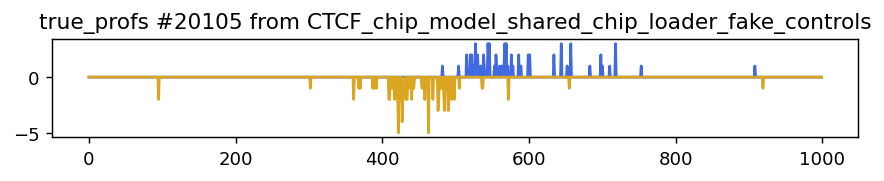

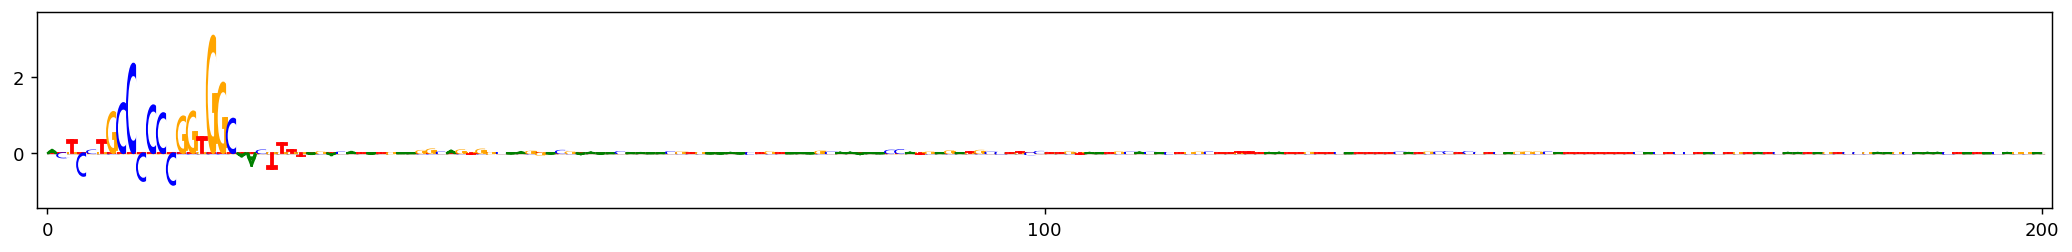

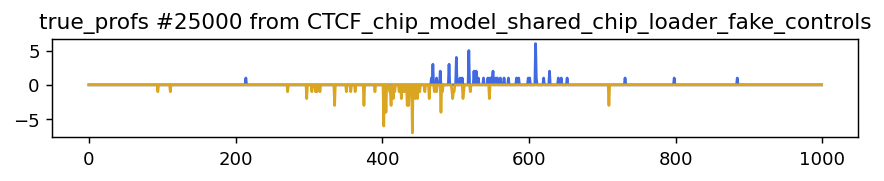

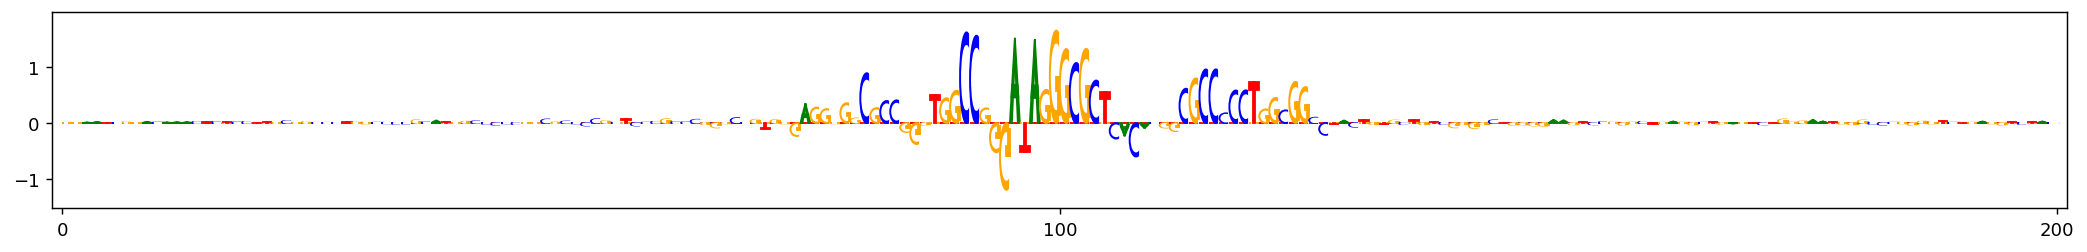

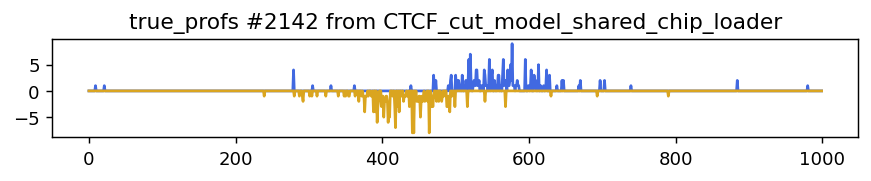

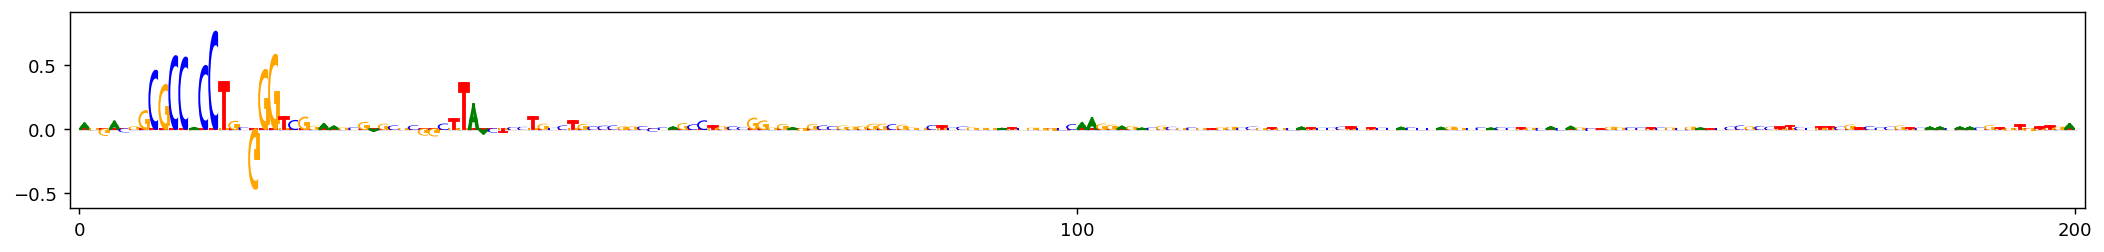

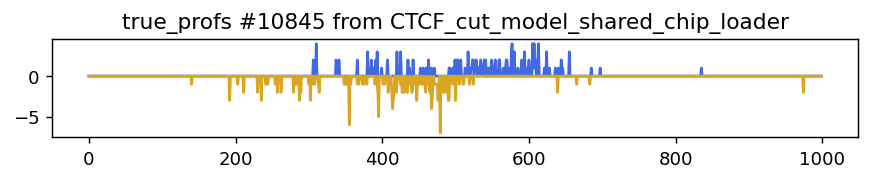

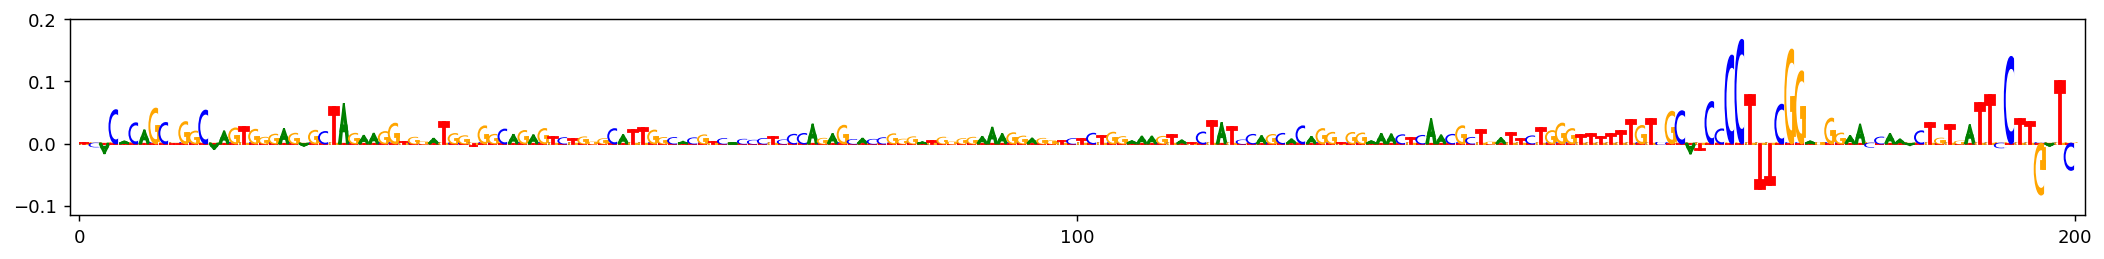

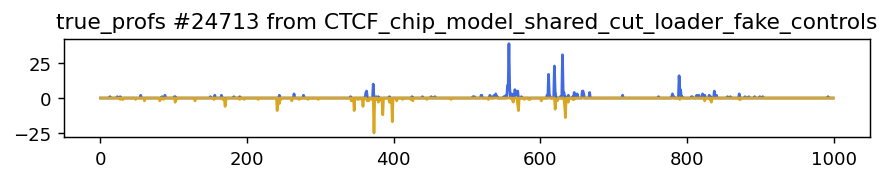

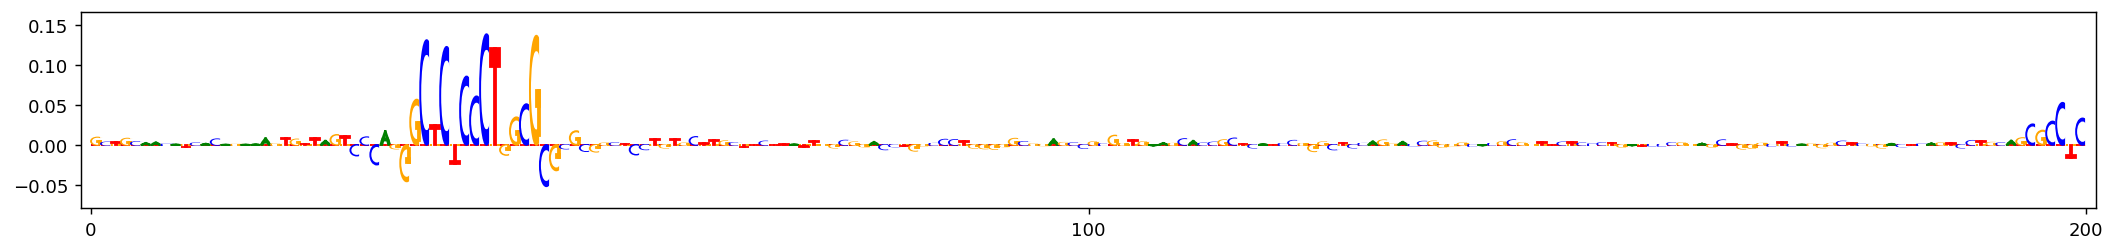

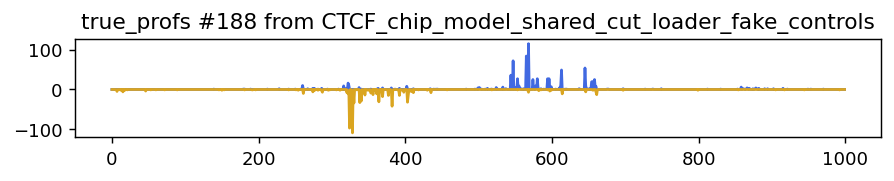

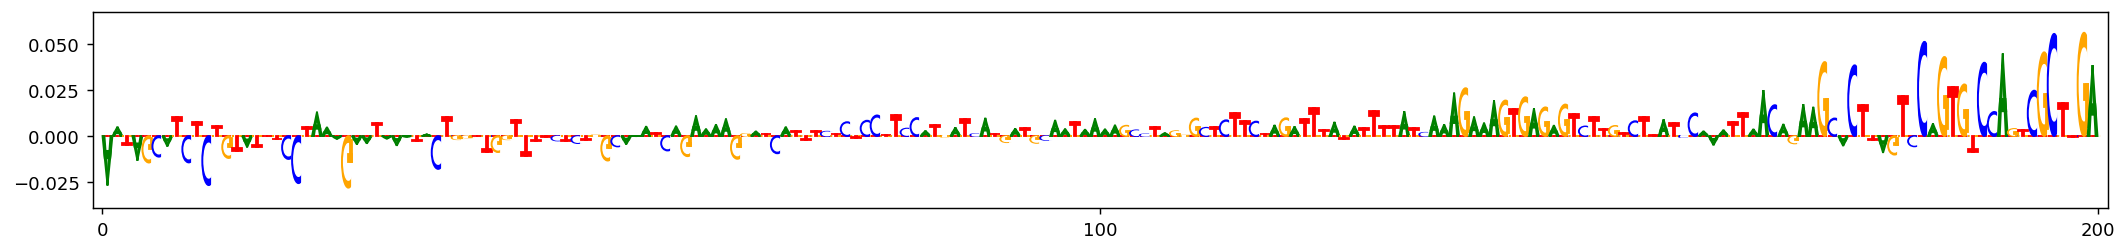

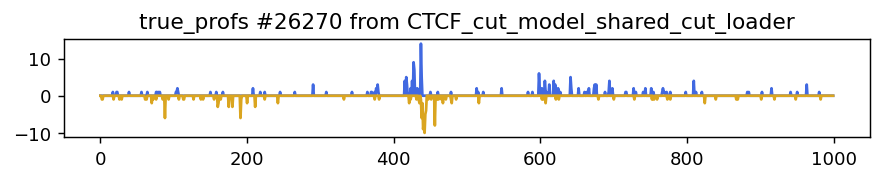

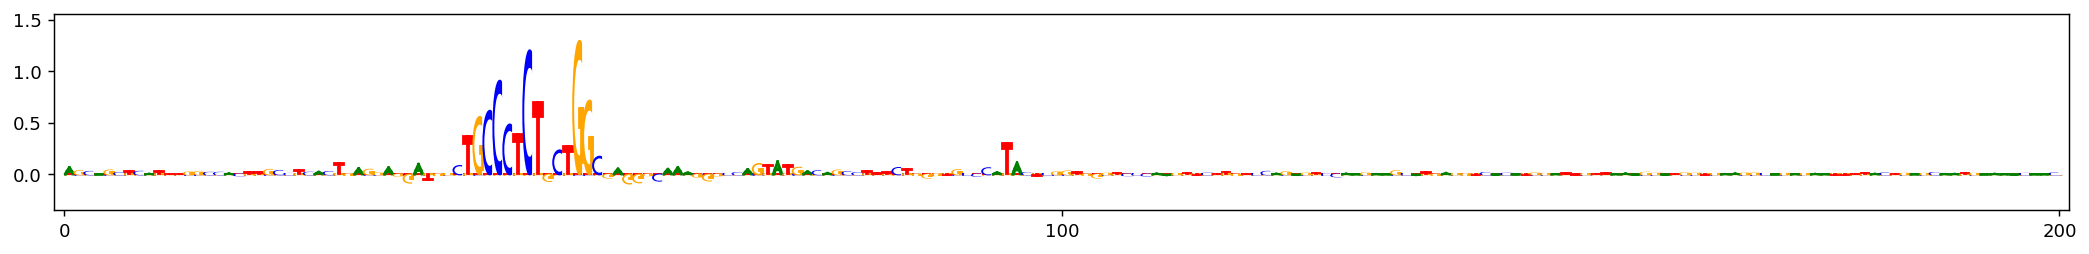

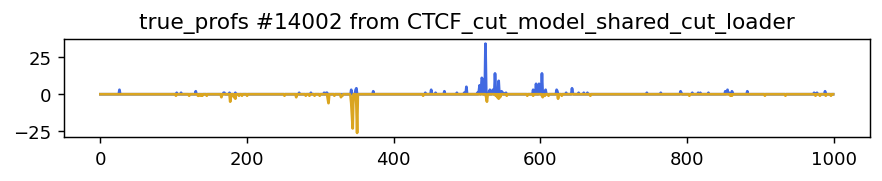

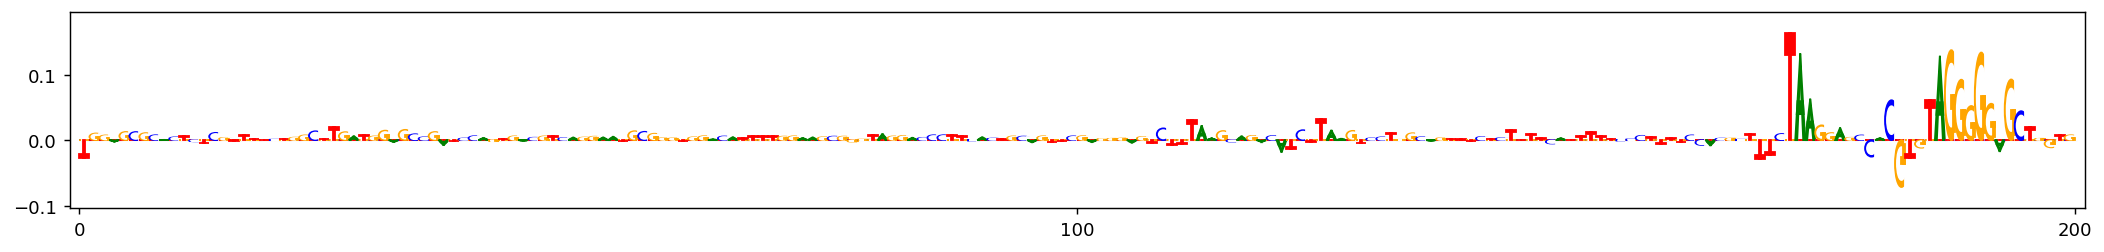

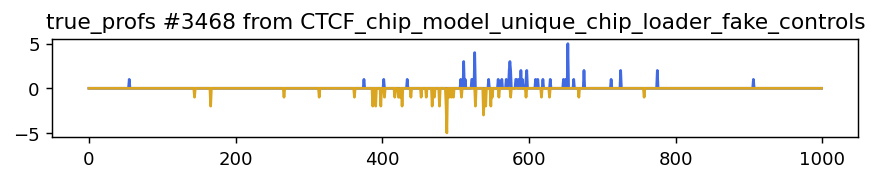

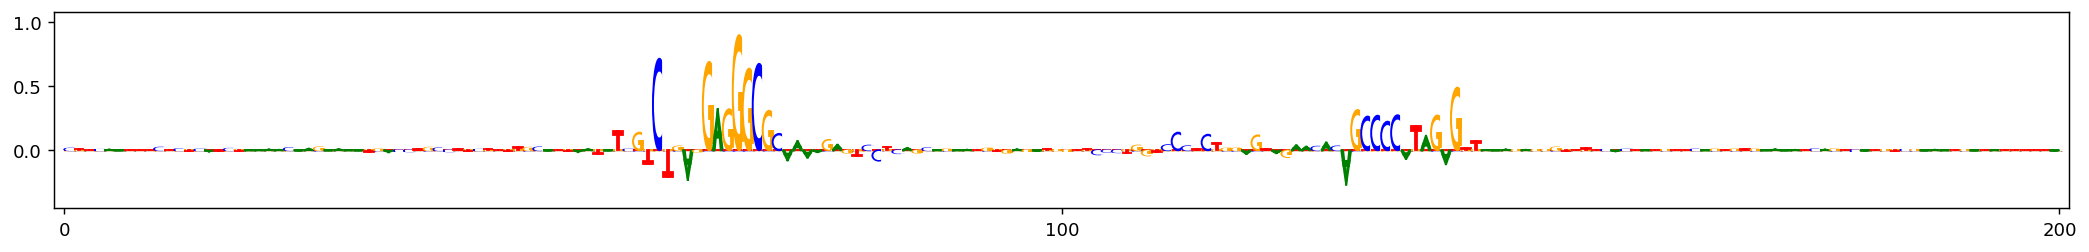

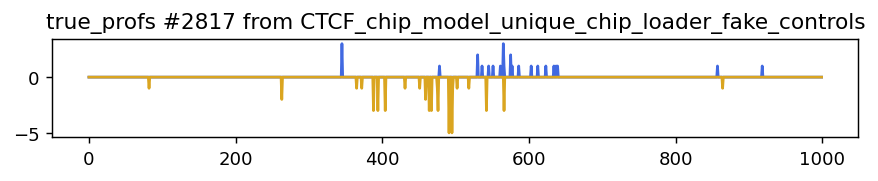

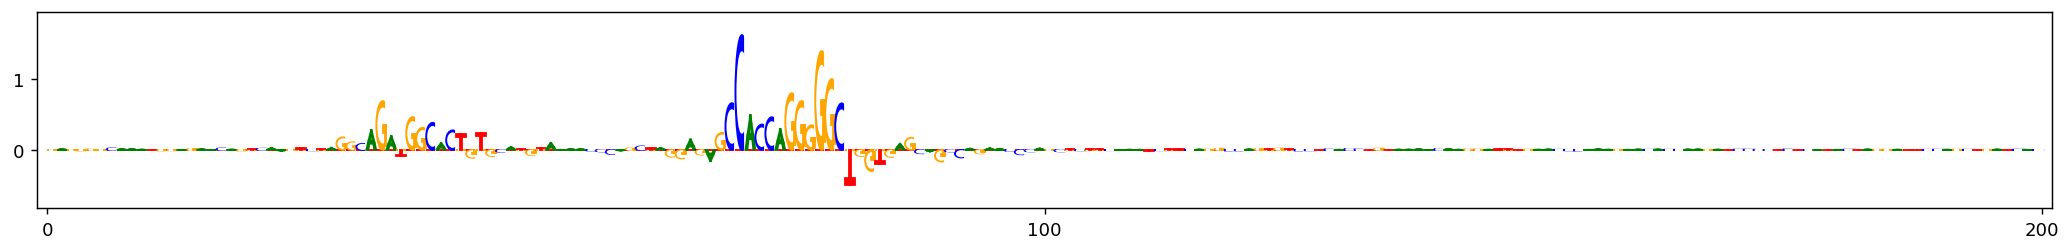

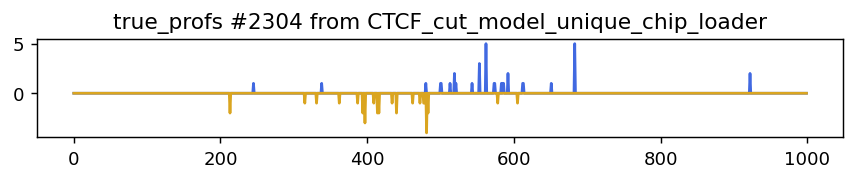

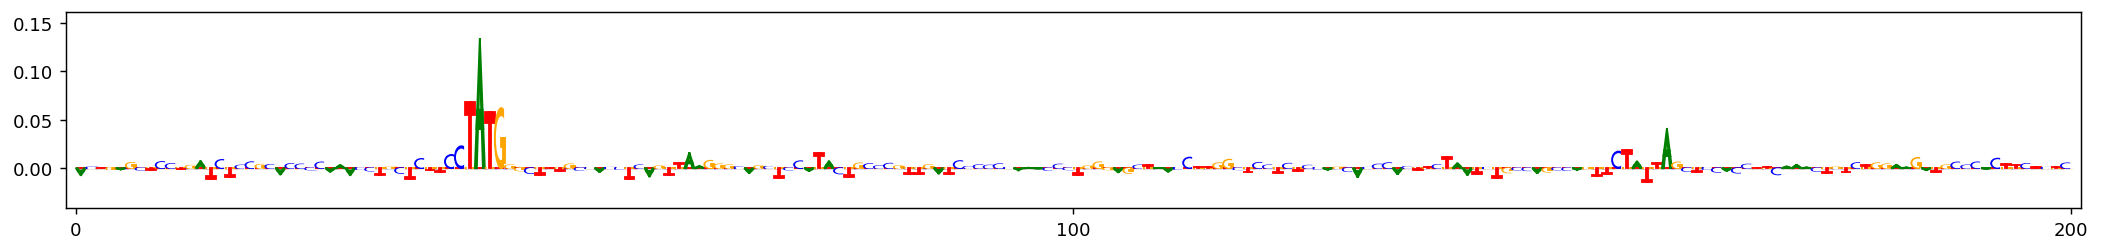

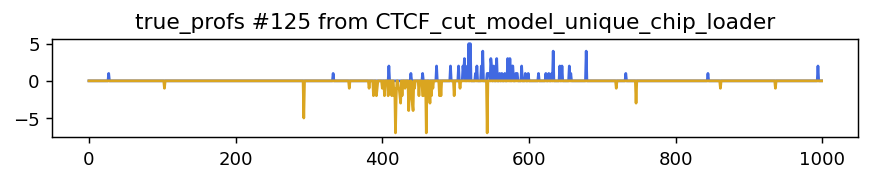

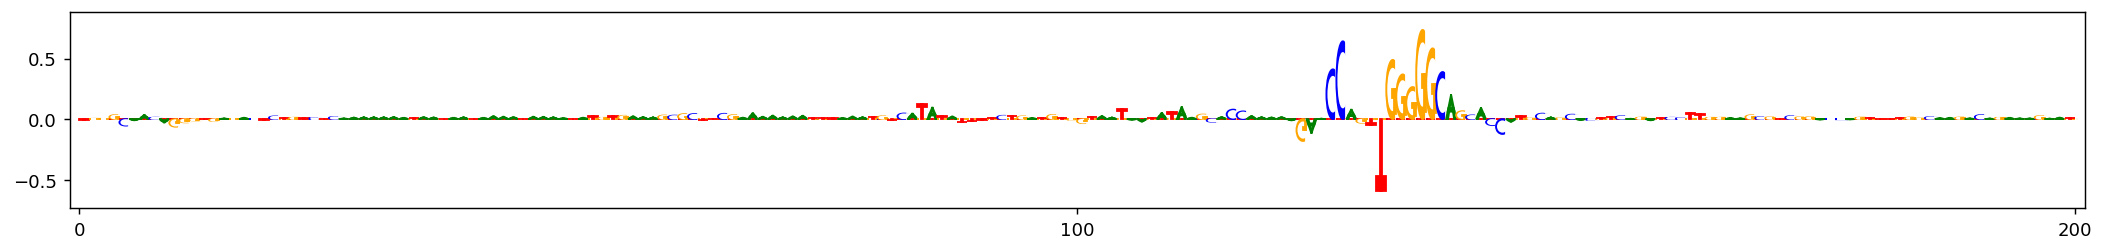

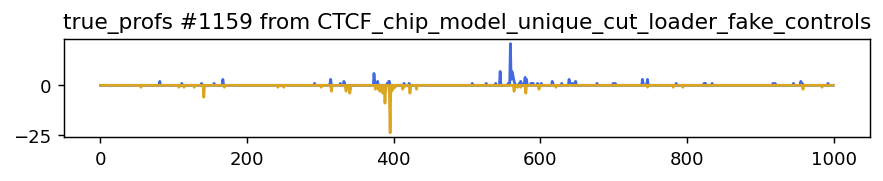

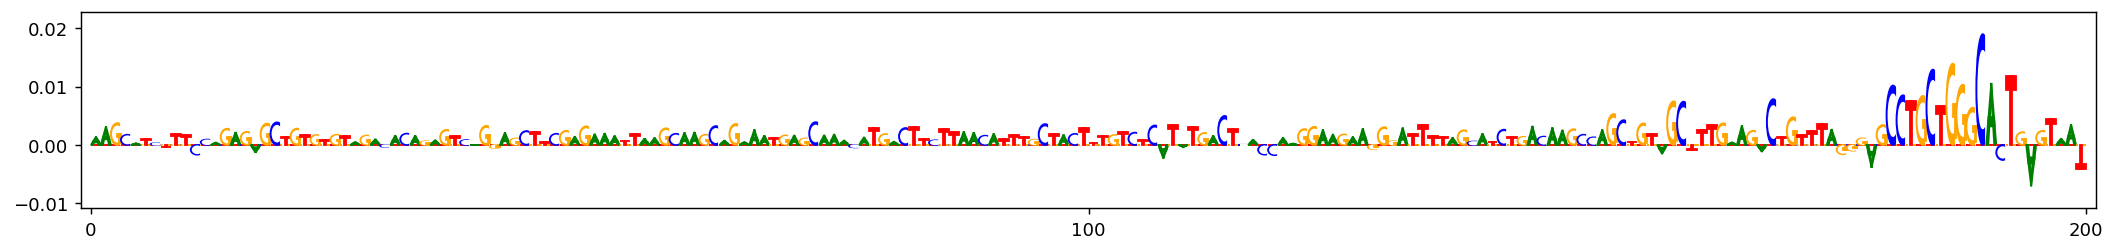

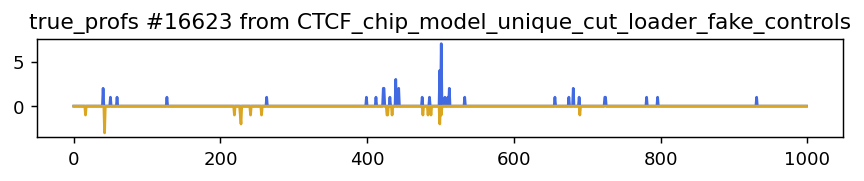

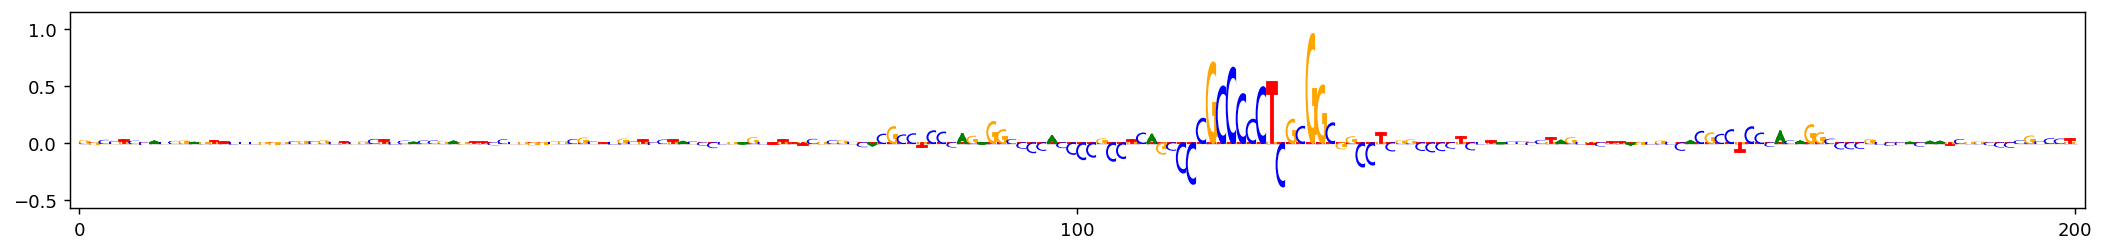

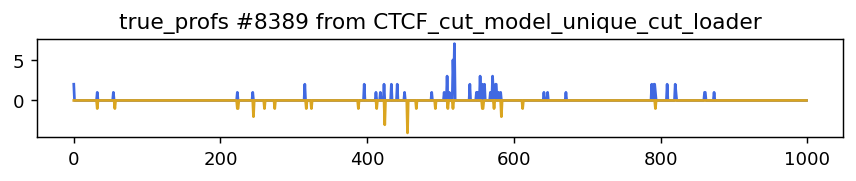

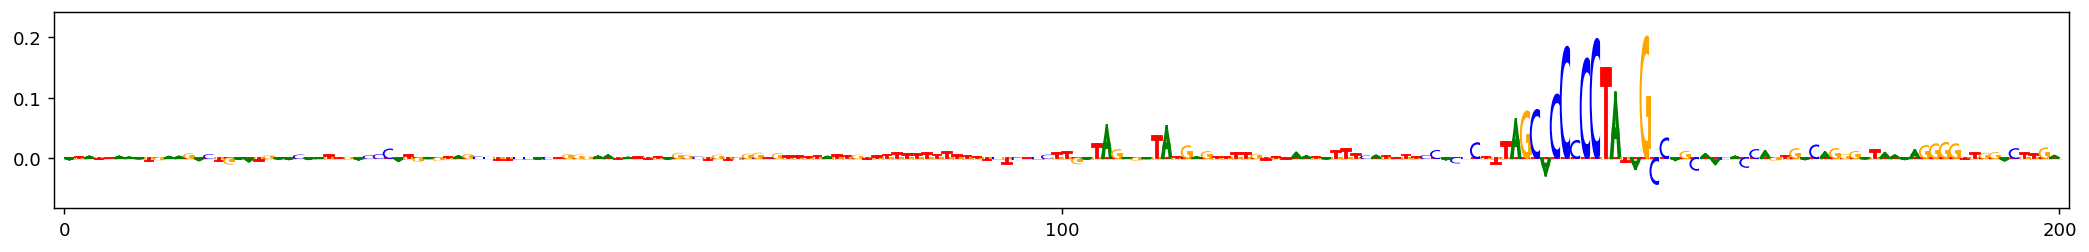

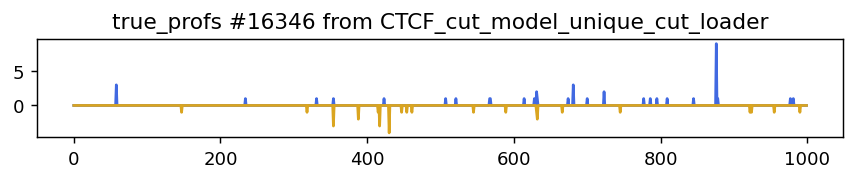

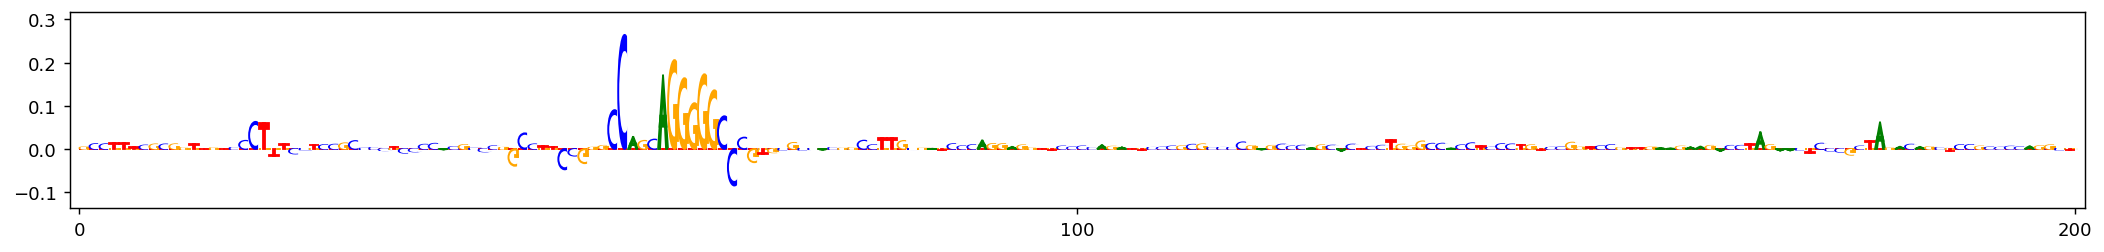

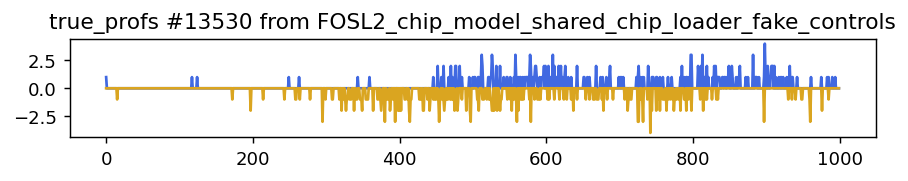

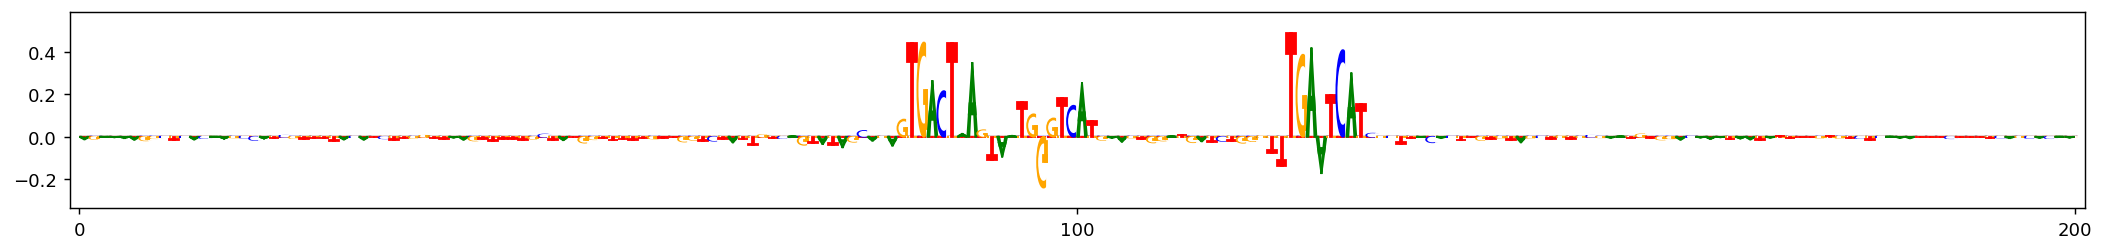

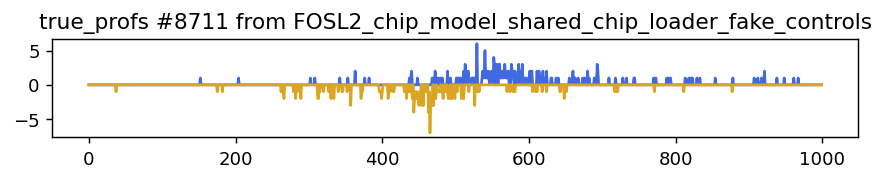

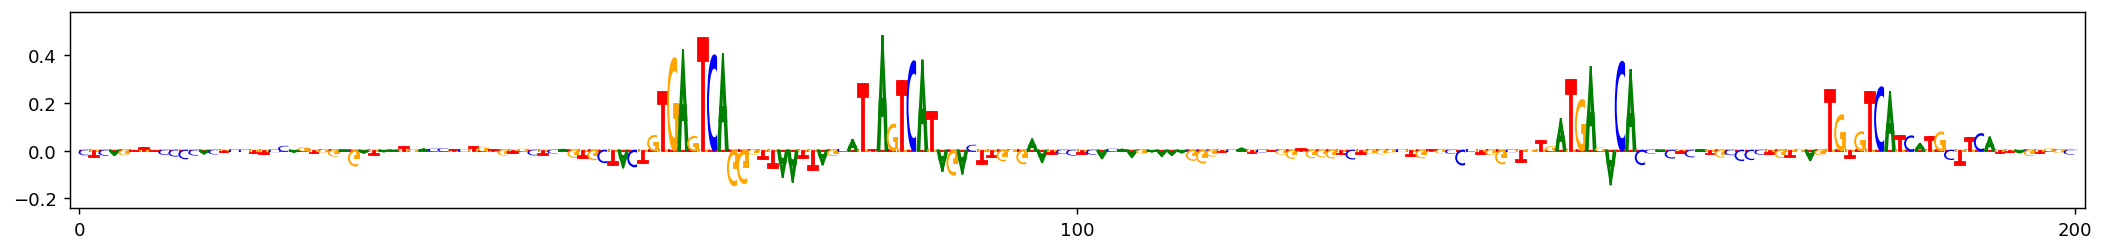

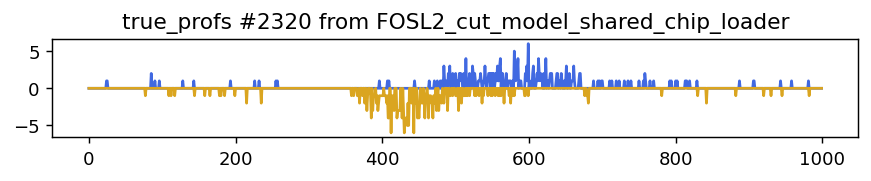

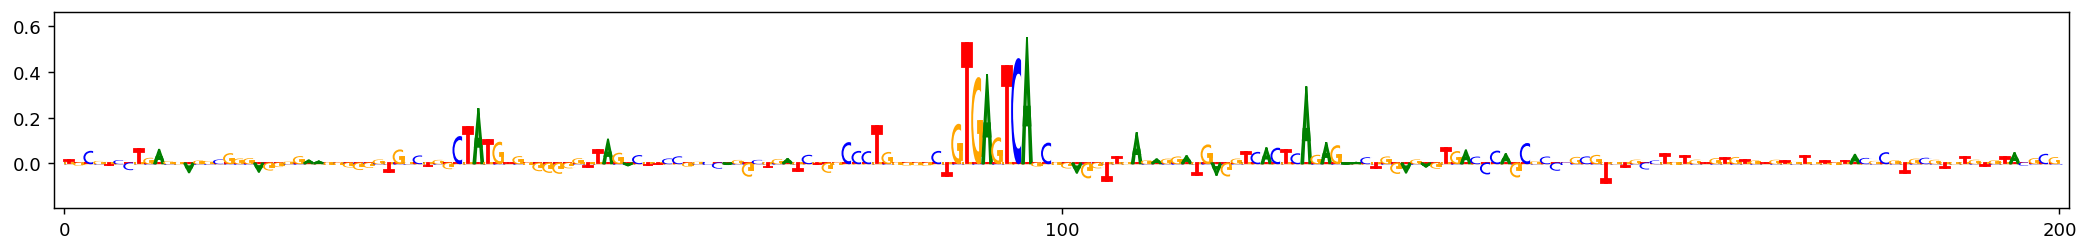

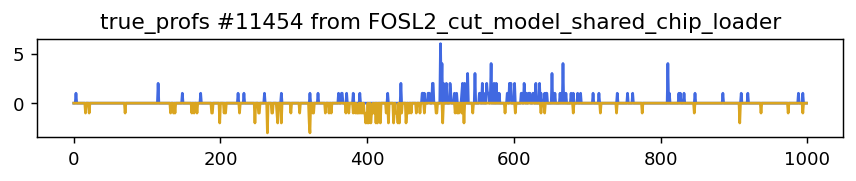

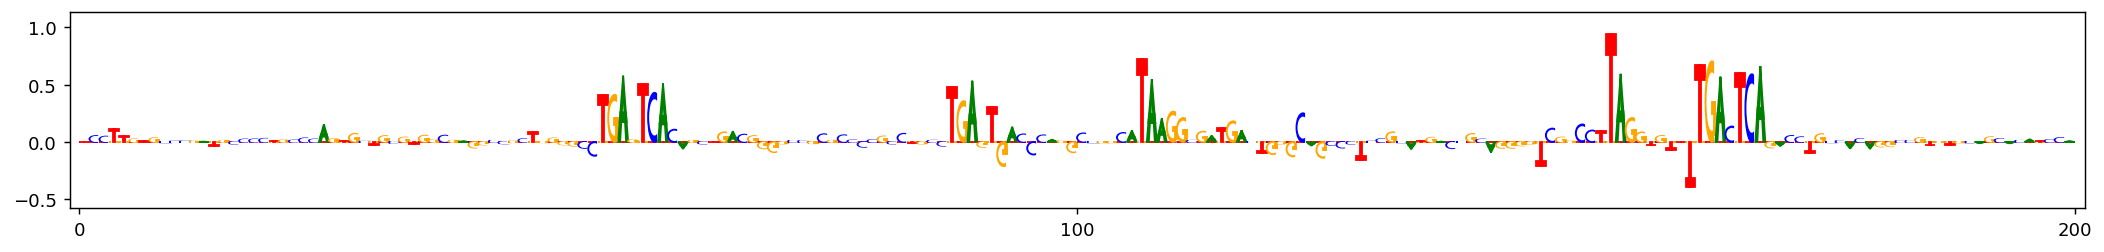

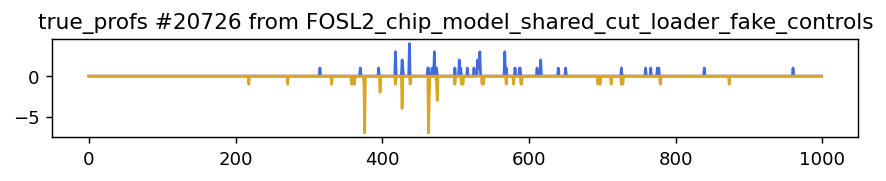

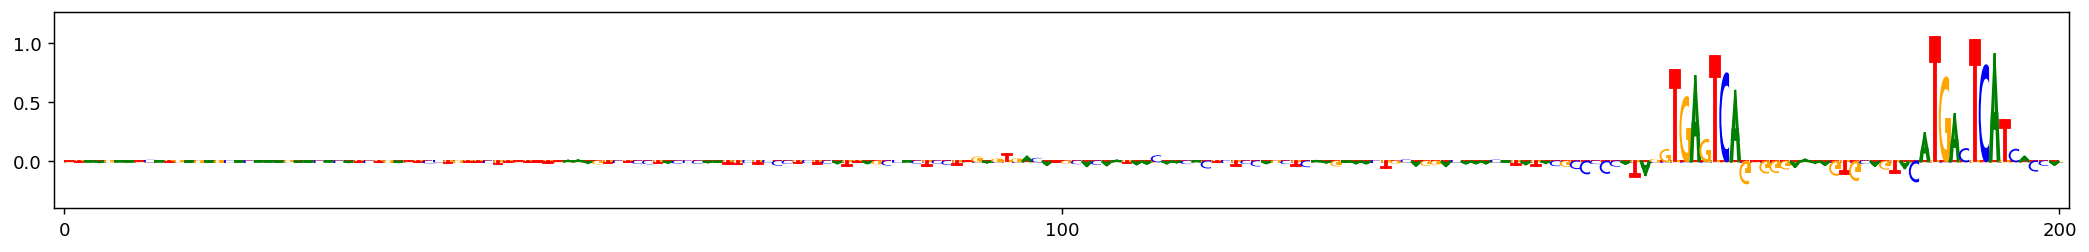

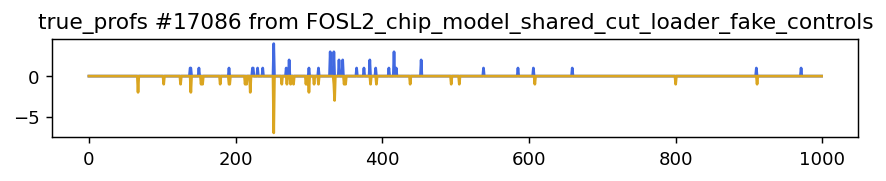

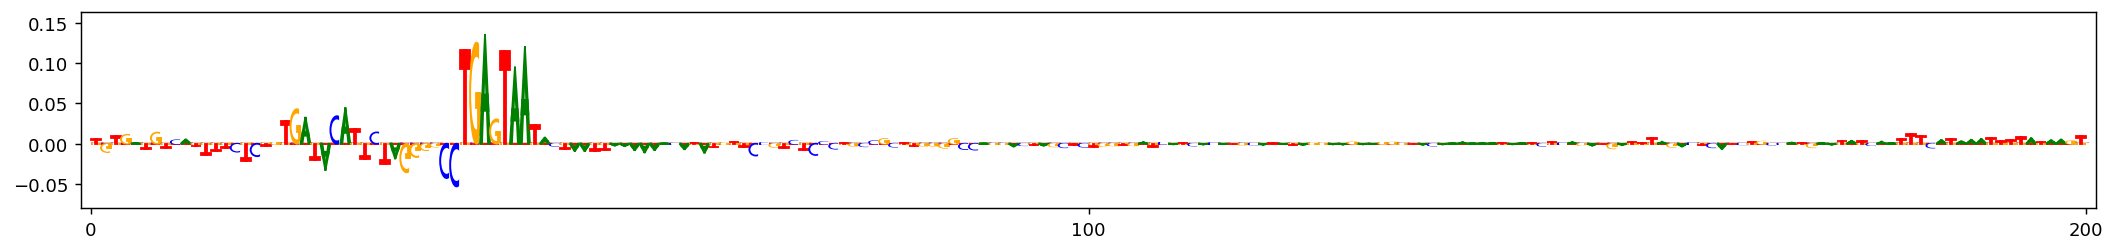

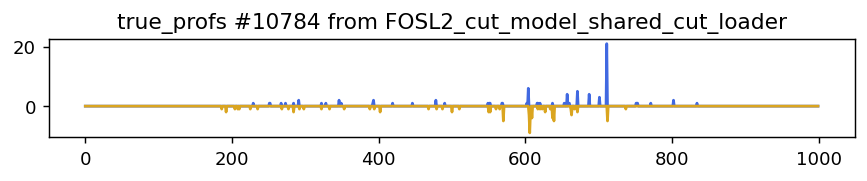

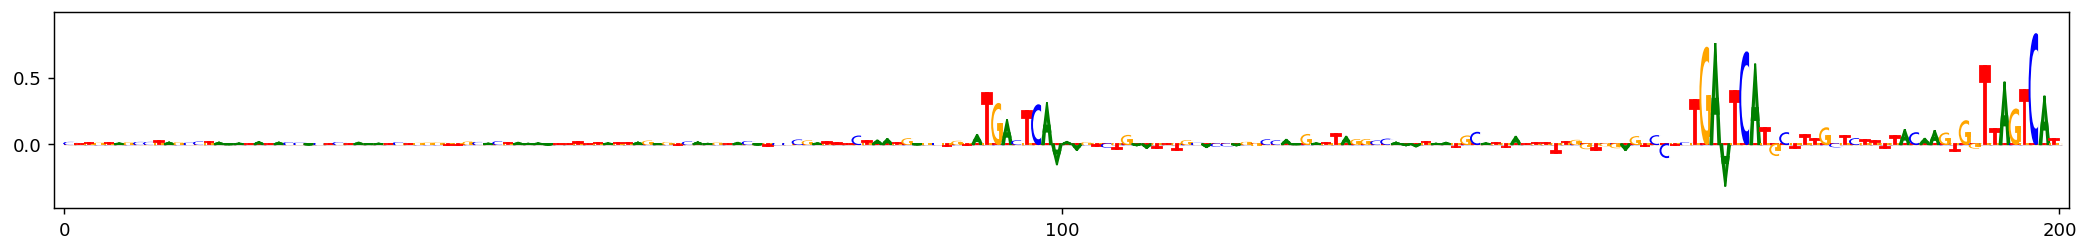

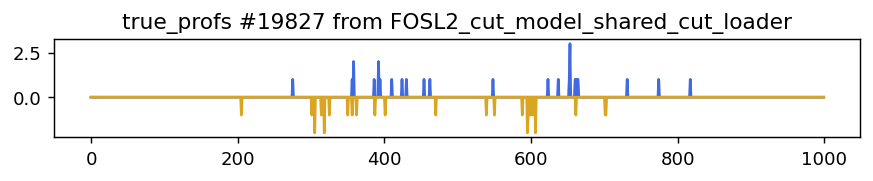

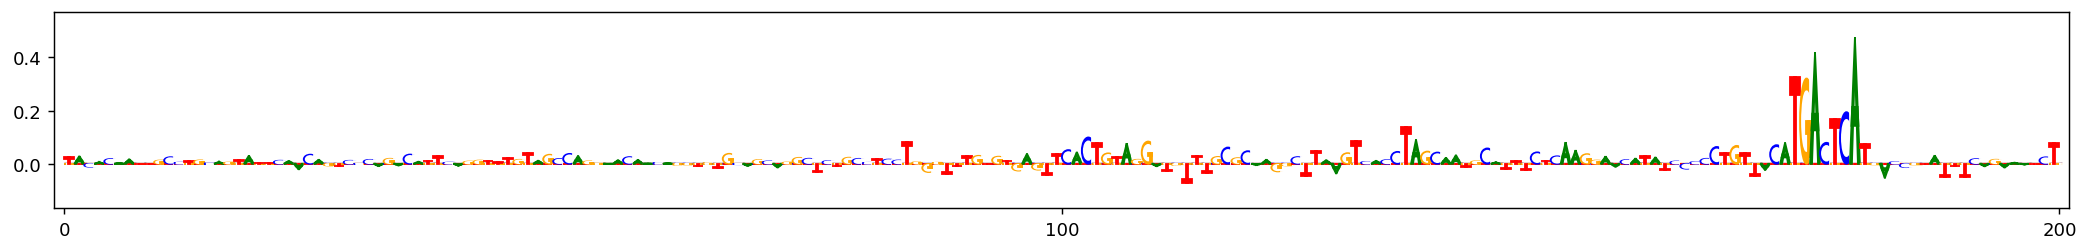

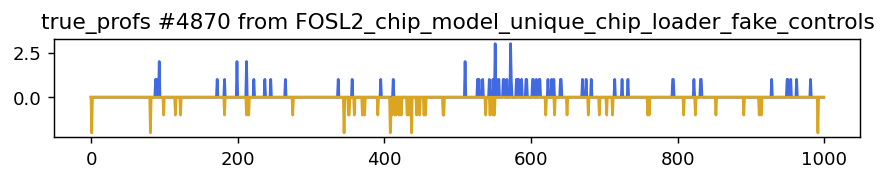

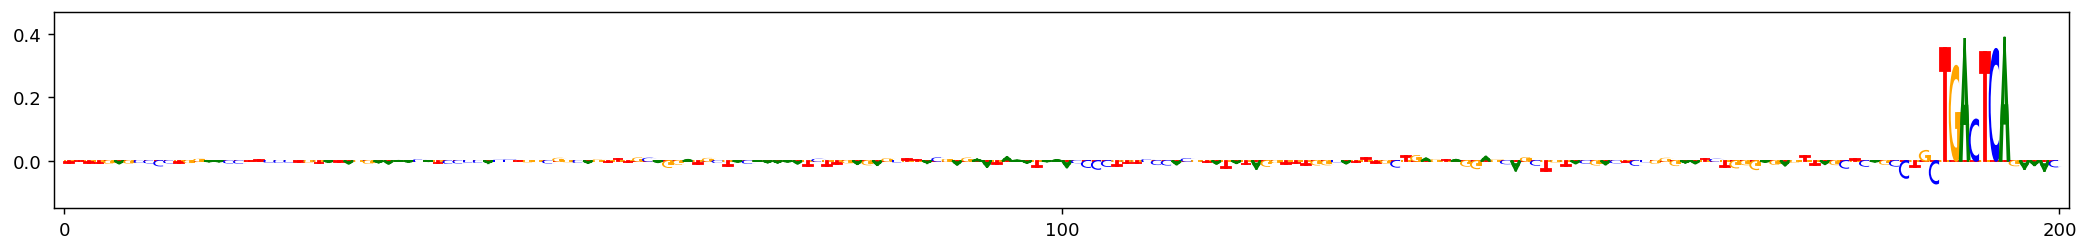

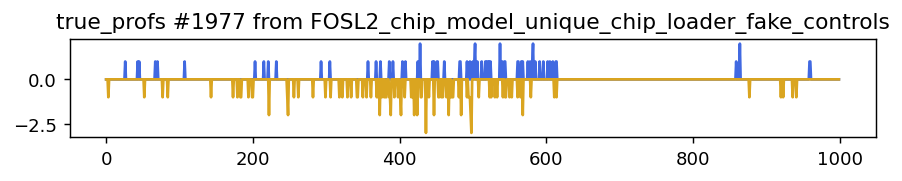

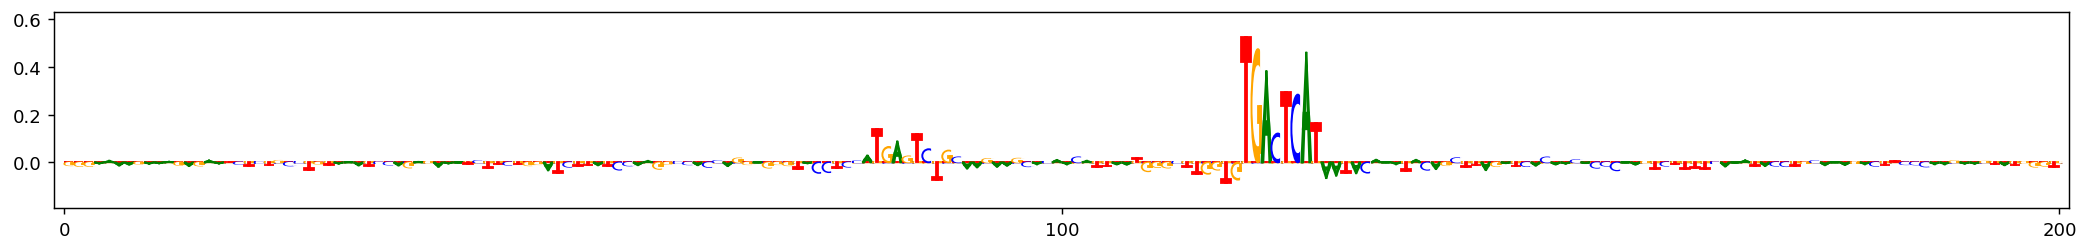

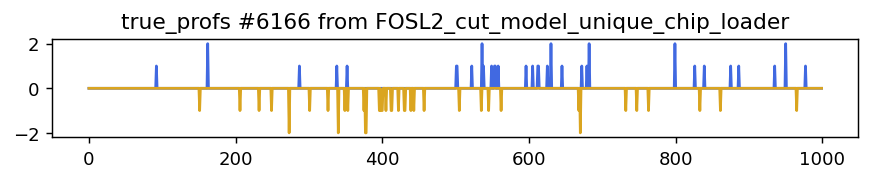

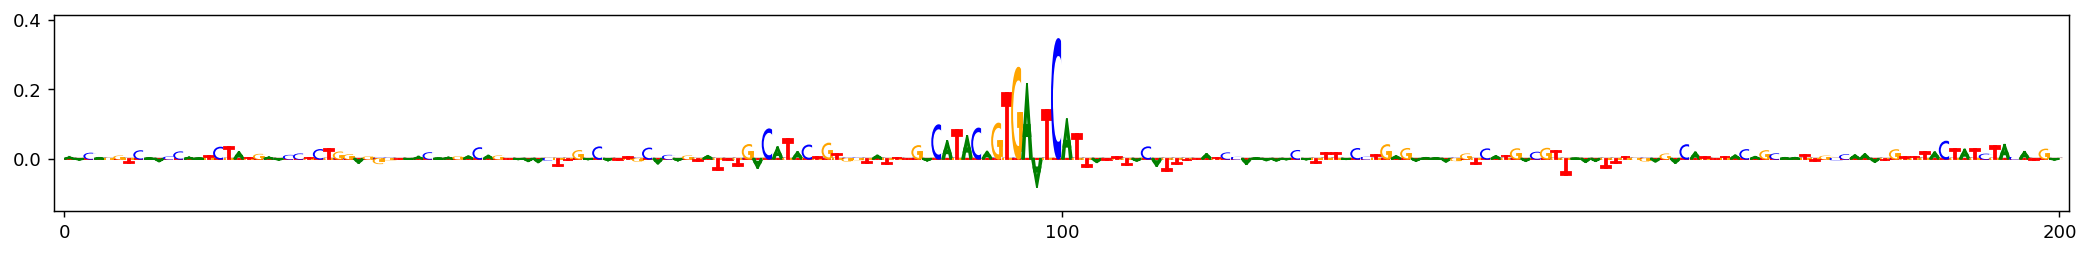

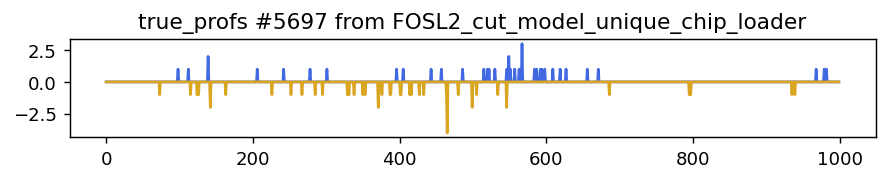

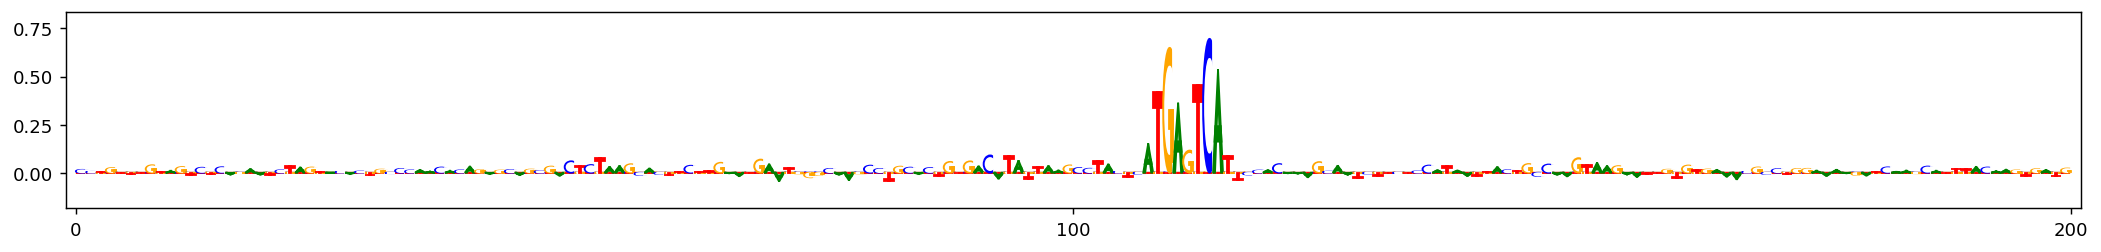

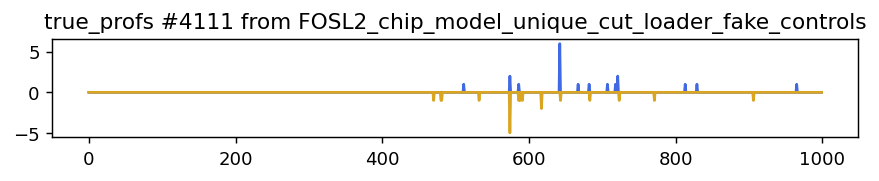

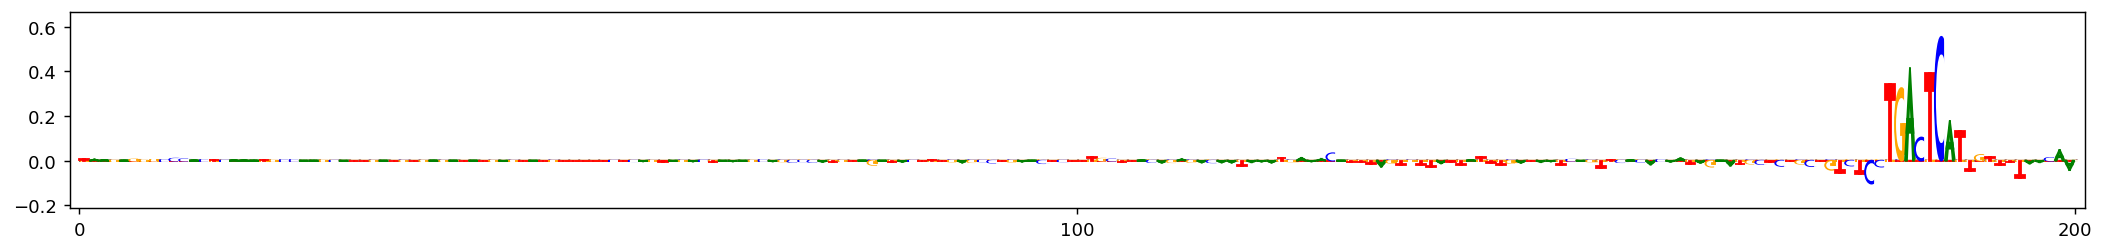

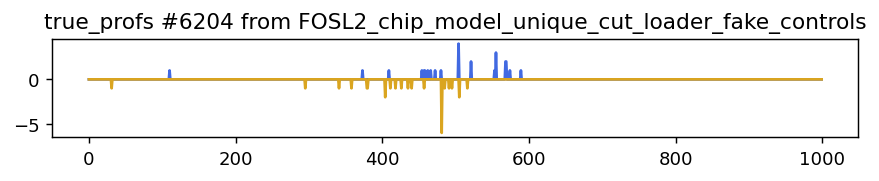

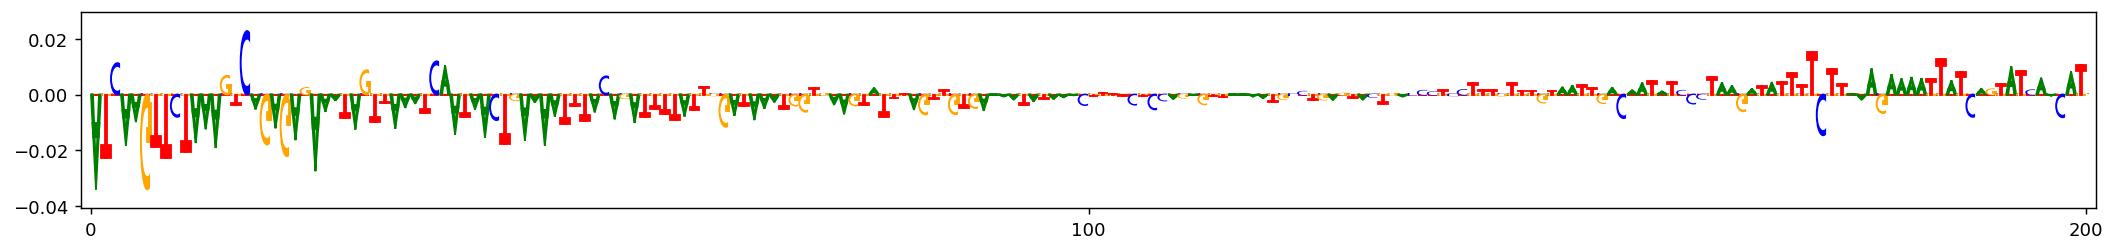

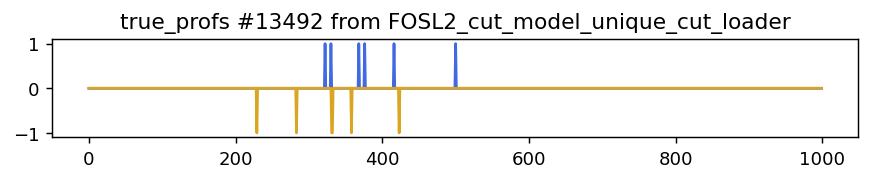

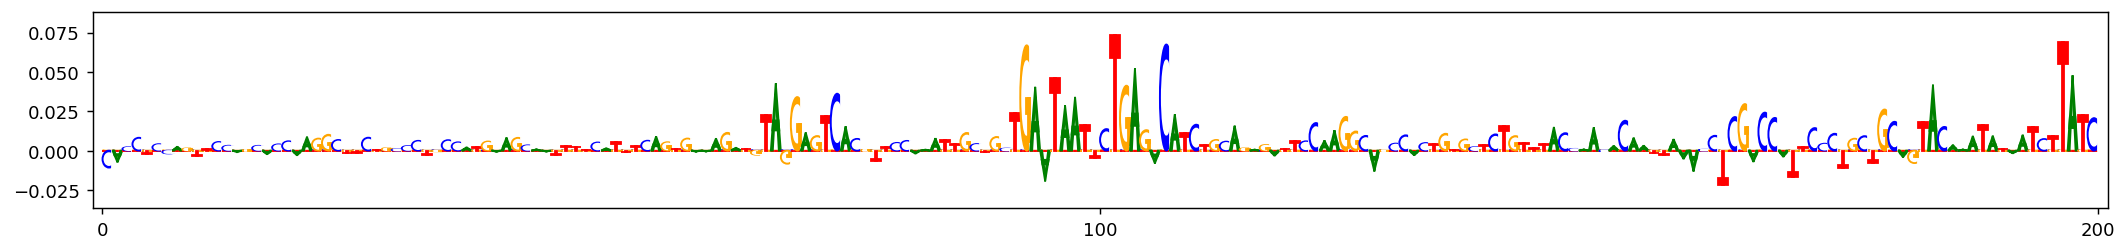

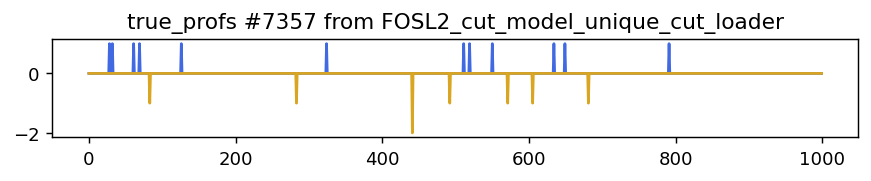

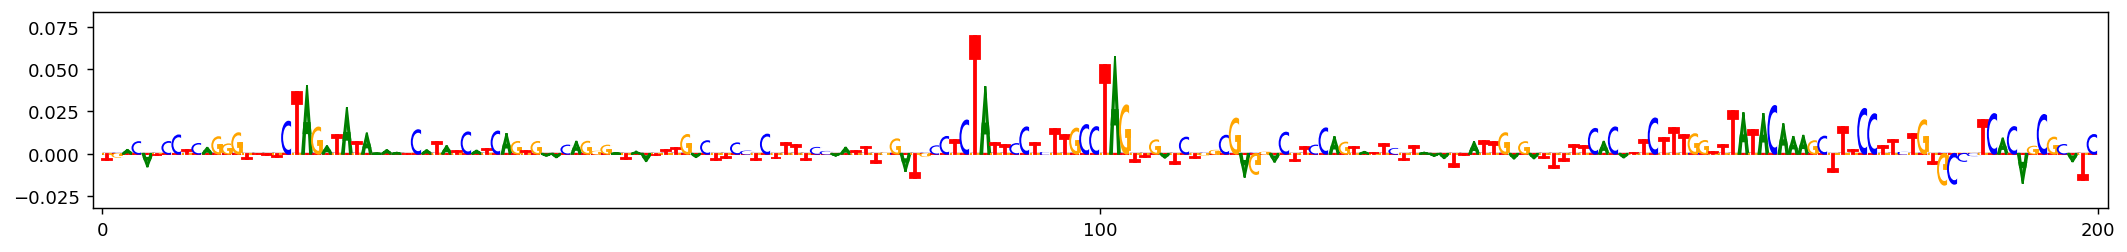

In [53]:
plot_examples_from_dict(preds_dict, subset='peaks_with_hit', indexes=indexes)

# ---------

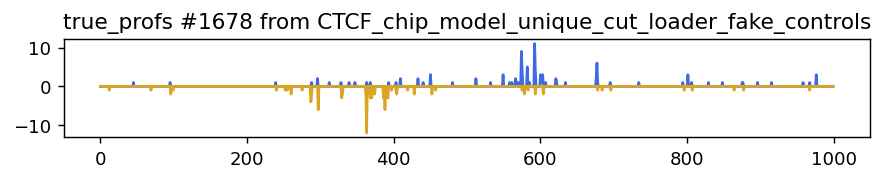

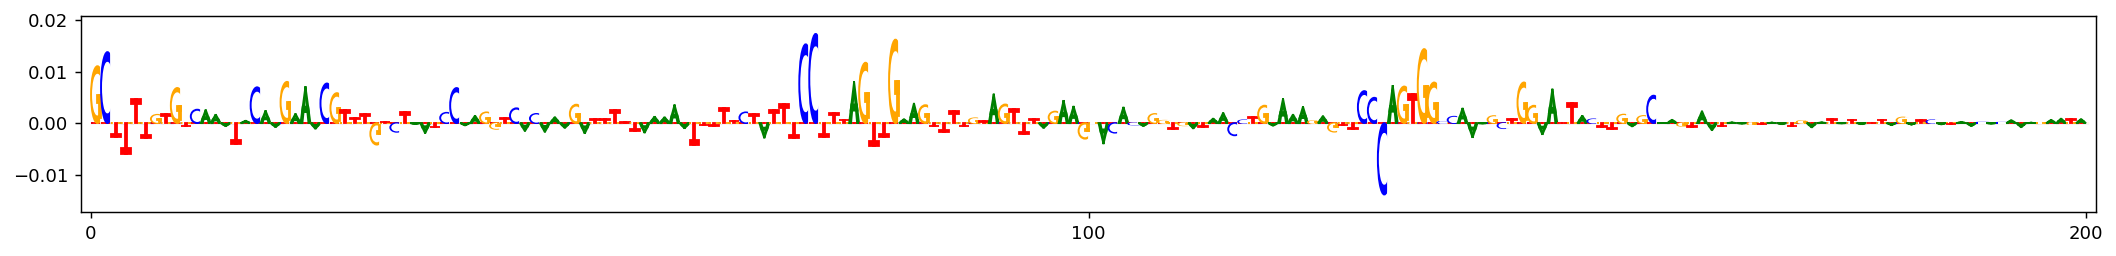

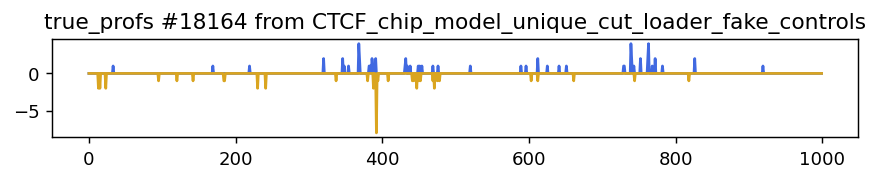

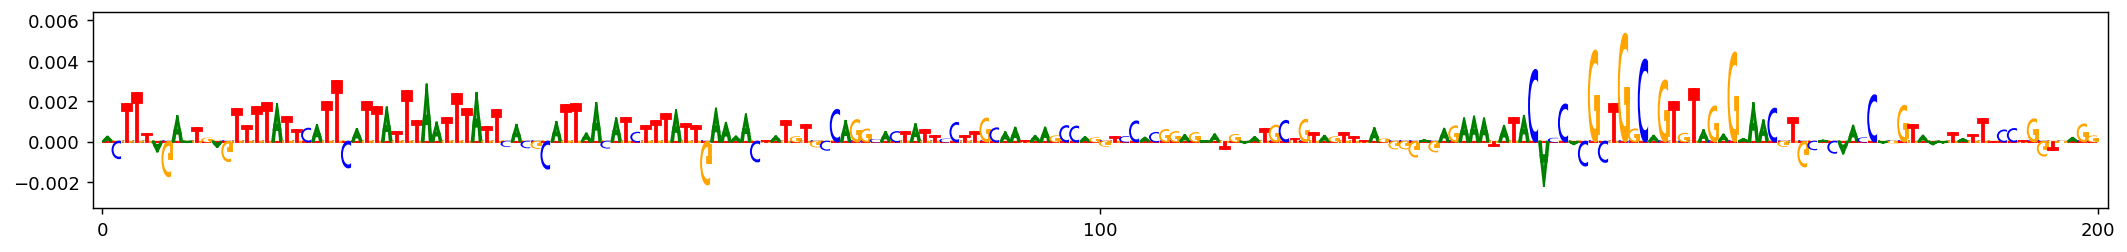

In [60]:
plot_examples_from_dict(preds_dict, subset='peaks_without_hit', indexes=indexes)